In [11]:
from sklearn.datasets import load_iris
import pandas
import numpy as np

iris_features = np.array(load_iris().data, dtype=np.float32)
iris_labels = np.array(load_iris().target, dtype=np.int32)
print(pandas.isna(iris_features).sum())
print(pandas.isna(iris_labels).sum())
# print(load_iris().data)
# print(iris_features)


0
0


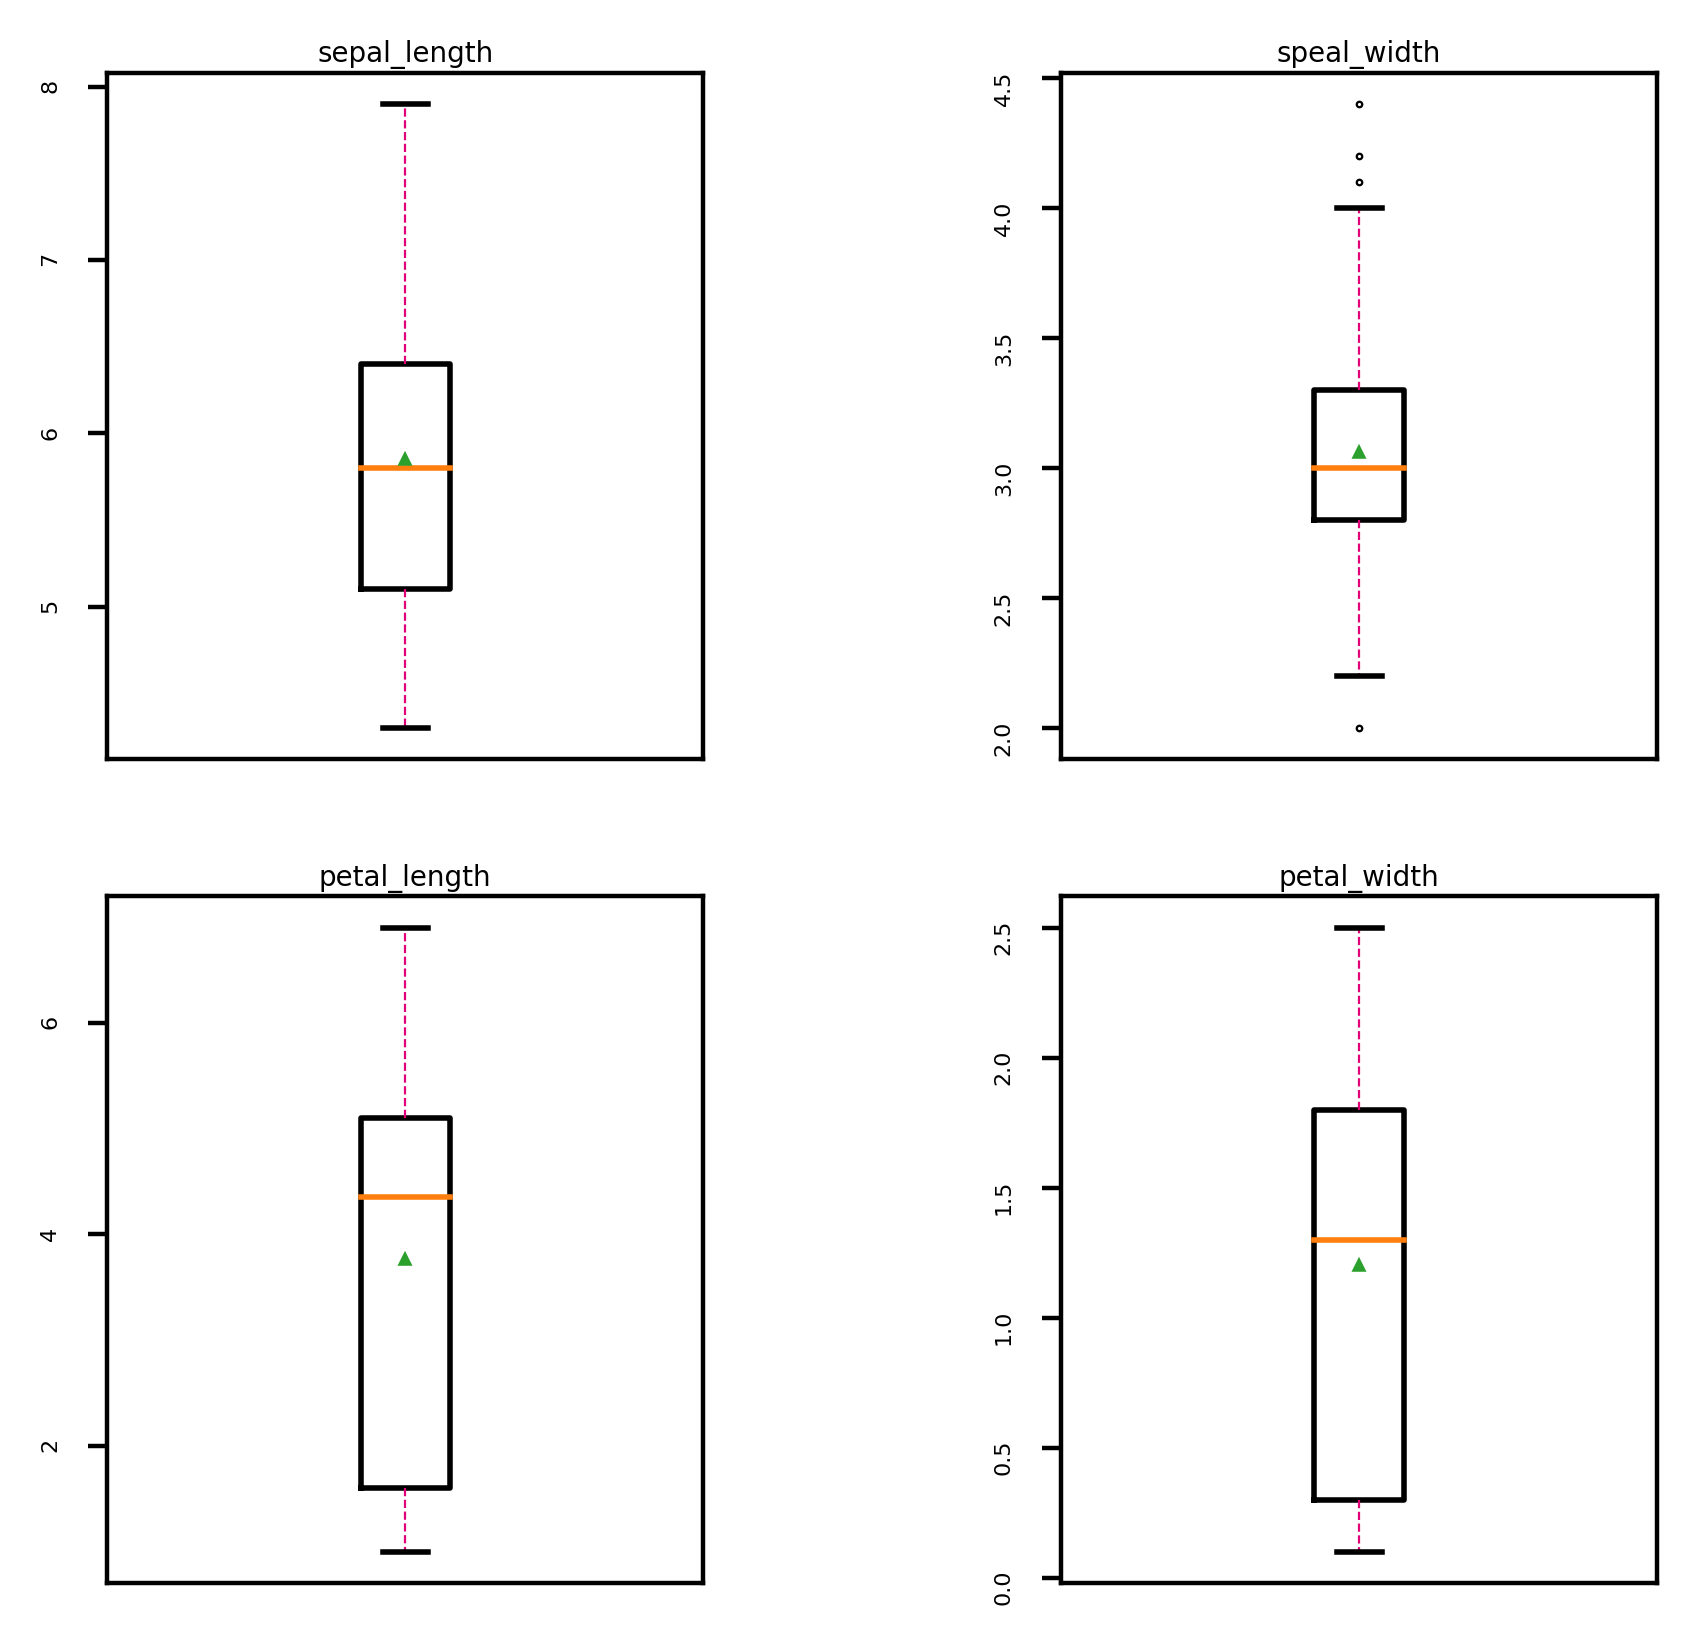

In [12]:
import matplotlib.pyplot as plt

# 箱线图查看异常值
def boxplot(features):
    features_name = ['sepal_length', 'speal_width', 'petal_length', 'petal_width']

    plt.figure(figsize=(5,5), dpi = 400)
    # 子图调整
    plt.subplots_adjust(wspace=0.6)
    # 每个特征画一个箱线图
    for i in range(len(features_name)):
        plt.subplot(2, 2, i+1)
        # 画箱线图
        plt.boxplot(features[:, i], showmeans= True,
                    whiskerprops={"color":"#E20079", "linewidth":0.4, 'linestyle':"--"},
                    flierprops={"markersize":0.4},
                    meanprops={"markersize":1})
        
        # 图名
        plt.title(features_name[i], fontdict={"size":5}, pad=2)

        # y方向刻度
        plt.yticks(fontsize = 4, rotation = 90)
        plt.tick_params(pad = 5)
        # x方向刻度
        plt.xticks([])
    plt.savefig('ml-vis.pdf')
    plt.show()

boxplot(iris_features)


In [13]:
# 数据读取

import copy
import paddle

# 加载数据集
def load_data(shuffle = True):
    """
    加载鸢尾花数据
    输入：
        - shuffle：是否打乱数据，数据类型为bool
    输出：
        - X：特征数据，shape=[150,4]
        - y：标签数据, shape=[150]
    """
    # 加载原始数据
    X = np.array(load_iris().data, dtype=np.float32)
    y = np.array(load_iris().target, dtype=np.int32)

    X = paddle.to_tensor(X)
    y = paddle.to_tensor(y)

    # 数据归一化
    X_min = paddle.min(X, axis=0)
    X_max = paddle.max(X, axis=0)
    X = (X-X_min) / (X_max-X_min)

    # 如果shuffle为True，随机打乱数据
    if shuffle:
         idx = paddle.randperm(X.shape[0])
         X = X[idx]
         y = y[idx]
    return X, y

# 固定随机种子
paddle.seed(102)

num_train = 120
num_dev = 15
num_test = 15

X, y = load_data(shuffle=True)
print("X shape:", X.shape, "y shape:", y.shape)
X_train, y_train = X[:num_train], y[:num_train]
X_dev, y_dev = X[num_train:num_train+num_dev], y[num_train:num_train+num_dev]
X_test, y_test = X[num_train+num_dev:],y[num_train+num_dev:]

# 打印X_train和y_train的维度
print("X_train shape:",X_train.shape, "y_train shape:",y_train.shape)

# 打印前5个数据的标签
print(y_train[:5])

X shape: [150, 4] y shape: [150]
X_train shape: [120, 4] y_train shape: [120]
Tensor(shape=[5], dtype=int32, place=Place(gpu:0), stop_gradient=True,
       [2, 0, 0, 0, 1])


In [14]:
# 模型构建
from nndl_3 import op

# 输入维度
input_dim = 4

# 类别数
output_dim = 3

# 实例化 Softmax 回归模型
model = op.model_SR(input_dim = input_dim, output_dim = output_dim)

In [15]:
# 模型训练

from nndl_3 import op, metric, opitimizer, RunnerV2

# 学习率
lr = 0.2

# 梯度下降法
optimizer = opitimizer.SimpleBatchGD(init_lr=lr, model=model)
# 交叉熵损失
loss_fn = op.MultiCrossEntropyLoss()
# 准确率
metric = metric.accuracy

# 实例化RunnerV2
runner = RunnerV2(model, optimizer, metric, loss_fn)

# 启动训练
runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=200, log_epochs=10, save_path="best_iris_model.pdparams")

best accuracy performence has been updated: 0.00000 --> 0.33333
[Train] epoch: 0, loss: 1.09861159324646, score: 0.3500000238418579
[Dev] epoch: 0, loss: 1.0872310400009155, score: 0.3333333432674408
best accuracy performence has been updated: 0.33333 --> 0.40000
best accuracy performence has been updated: 0.40000 --> 0.46667
best accuracy performence has been updated: 0.46667 --> 0.60000
[Train] epoch: 10, loss: 0.9777340292930603, score: 0.7000000476837158
[Dev] epoch: 10, loss: 0.998892605304718, score: 0.6000000238418579
[Train] epoch: 20, loss: 0.8945356011390686, score: 0.7000000476837158
[Dev] epoch: 20, loss: 0.9269810318946838, score: 0.6000000238418579
[Train] epoch: 30, loss: 0.8285729289054871, score: 0.7000000476837158
[Dev] epoch: 30, loss: 0.8667001128196716, score: 0.6000000238418579
[Train] epoch: 40, loss: 0.7752518653869629, score: 0.7000000476837158
[Dev] epoch: 40, loss: 0.8166458606719971, score: 0.6000000238418579
[Train] epoch: 50, loss: 0.7315736413002014, scor

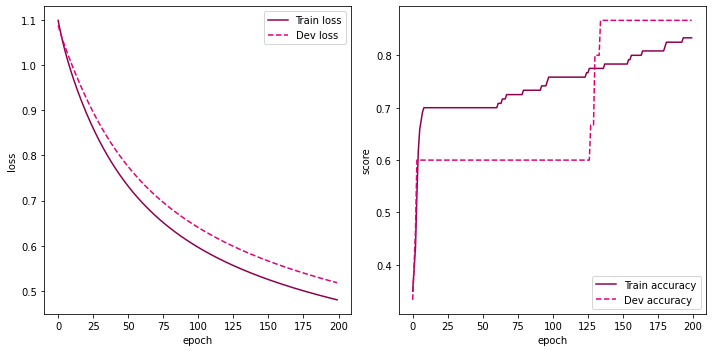

In [16]:
from nndl_3 import plot

plot(runner, fig_name = 'linear-acc3.pdf')

In [17]:
# 模型评价
runner.load_model('best_iris_model.pdparams')

# 模型评价
score, loss = runner.evaluate([X_test, y_test])
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.6667/0.6573


In [18]:
# 预测测试集数据
logits = runner.predict(X_test)
# op.py forward()
# print(logits)
pred = paddle.argmax(logits[0]).numpy()
# print(pred)

# 获取该样本概率最大的类别
label = y_test[0].numpy()
# print(y_test)

# 输出真实类别与预测类别
print("The true category is {} and the predicted category is {}".format(label[0], pred[0]))

The true category is 1 and the predicted category is 2
